In [4]:
%load_ext autoreload
%autoreload 2

import parse_hipnogram as ph
from parse_signal import load_psg, load_neuroon


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal as sig
import seaborn as sns
import h5py
import scipy.signal as sig
from collections import OrderedDict 

from plotting_collection import plot_spectra_by_stage

%matplotlib notebook
stage_color_dict = {'N1' : 'royalblue', 'N2' :'forestgreen', 'N3' : 'coral', 'rem' : 'plum', 'wake' : 'lightgray' }


/Users/user/.virtualenvs/notebook/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


loading


In [5]:
def analyze_sleep_stage_spectrum(night):
    # prep_for_spectral rearrenges the rows to have start timestamp and end timestamp in the same row 

    neuroon_hipnogram = ph.prep_for_spectral(ph.parse_neuroon_stages(night = night))
    psg_hipnogram = ph.prep_for_spectral(ph.parse_psg_stages(night = night))

    # Load the eeg signals
    psg_signal =  load_psg('F3-A2', night = night)
    neuroon_signal =  load_neuroon(night = night)

    # Cut the signal into epochs corresponding to occurence of a sleep stage
    # and calculate the power spectrum for each epoch
    _, neuroon_spectra, neuroon_frequency = make_stage_slices(125, neuroon_hipnogram, neuroon_signal)
    _, psg_spectra, psg_frequency = make_stage_slices(200, psg_hipnogram, psg_signal)


    band = plot_spectra_by_stage(neuroon_spectra, neuroon_frequency,'neuroon', min_freq = 1, max_freq = 3)
    band = plot_spectra_by_stage(psg_spectra, psg_frequency,'psg',  min_freq = 1, max_freq = 3)


In [6]:
# Iterate over each case when hipnogram detected a sleep stage and cut a corresponding signal slice
def make_stage_slices(sampling_rate, hipno, signal):
    # Prepare dicts to store the slices and their spectrea with frequency bins information
    slices = {}
    spectra = {}
    frequency = {}
    
    # Iterate over each sleep stage category
    for name, sleep_stage in hipno.groupby('stage_name'):
        stage_spectra = []
        stage_slices = []
        stage_freqs = []
        # iterate over each occurence of a sleep stage
        for idx, phase_event in sleep_stage.iterrows():
            # Cut corresponding slice of eeg signals
            _slice = np.array(signal.loc[phase_event['starts'] : phase_event['ends']])
            # Check if it exists, this will only fail at the last psg slice of the wake phase which lasted for 1 sample...
            if(_slice.size >  1):
                # Store the raw signal
                stage_slices.append(_slice)
                # Compute and store signal spectral density
                freqs, pxx = sig.welch(_slice, fs = sampling_rate, nperseg=1024, noverlap = 256) 
                # pxx is the power density at frequency described by freqs array
                stage_spectra.append(pxx)
                # Save the frequency labels for indices of the pxx
                stage_freqs.append(freqs)
            
        slices[name] = stage_slices
        spectra[name] = np.array(stage_spectra)
        frequency[name] = np.array(stage_freqs)
        
    return slices, spectra, frequency
    
    

/Users/user/.virtualenvs/notebook/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
parse_hipnogram.py:76: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  neuroon_stages = neuroon_stages.sort(columns = 'timestamp')
/Users/user/.virtualenvs/notebook/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/user/.virtualenvs/notebook/lib/python2.7/site

<IPython.core.display.Javascript object>


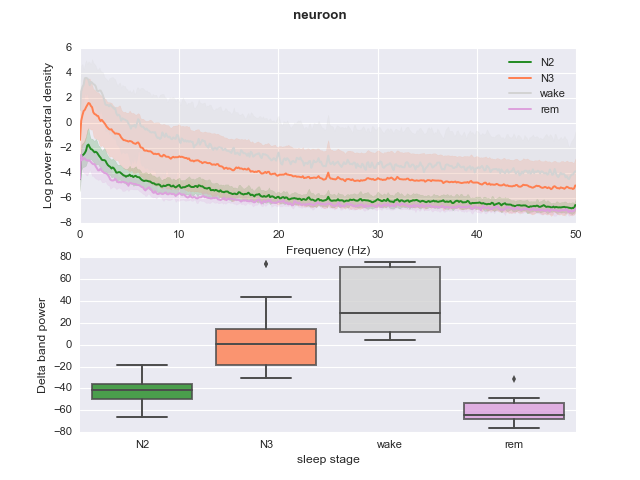

<IPython.core.display.Javascript object>


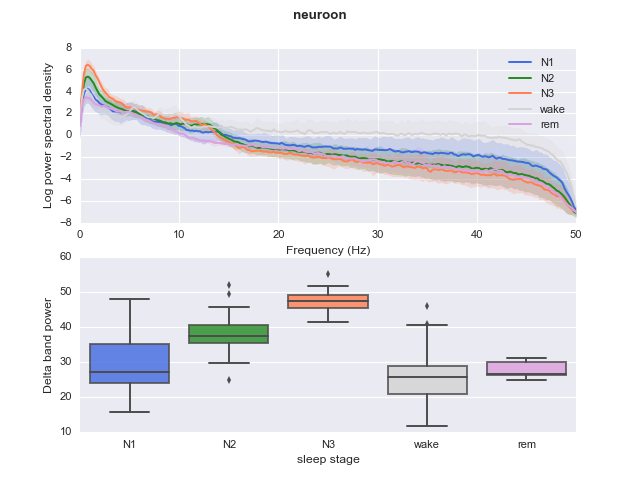

In [7]:
analyze_sleep_stage_spectrum(night = 1)

<IPython.core.display.Javascript object>


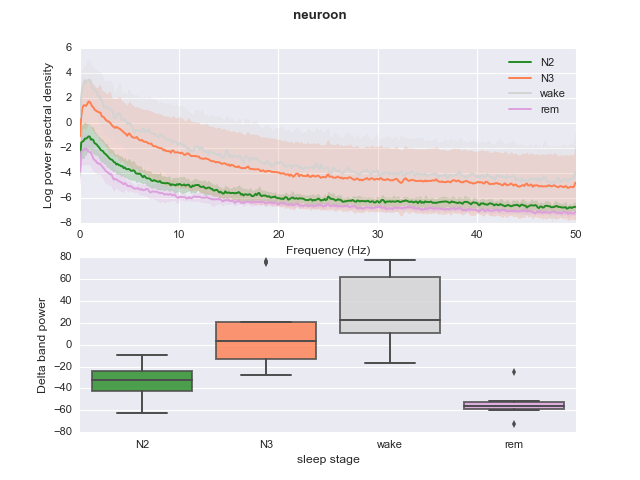

<IPython.core.display.Javascript object>


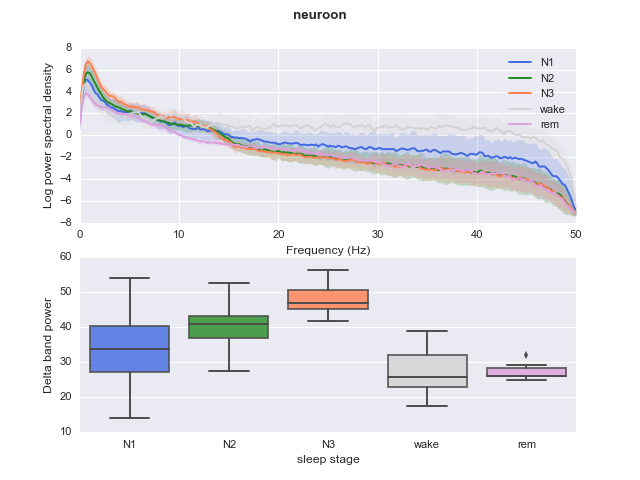

In [8]:
analyze_sleep_stage_spectrum(night = 2)